# Question 2 : Resolution analysis :
Poly:
https://josselin-garnier.org/wp-content/uploads/2025/01/polycopie-mva-2025.pdf#page=44.47

In [39]:
import numpy as np

In [40]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [41]:
import numpy as np

In [42]:
# 1 La green function  on approxime par la partie1


class Green:
    def __init__(self):

        pass

    def __call__(self, w, x, y):
        return (1 / (4 * np.pi * np.linalg.norm(x - y))) * np.exp(
            1j * w * np.linalg.norm(x - y)
        )


f = Green()
f(0, 5, 0)
# f(0,xn[0],zref)

f(1, 5, 6)

(0.04299589137143181+0.06696213335029096j)

In [43]:
# On introduit ici R_n
rho_ref = 1


class R_n:
    # correspond à Rnchapeau
    def __init__(self, rho_ref, f0, f1, zref, xn):
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.xn = xn
        self.zref = zref
        self.green = Green()

    def __call__(self, n, w):
        def rn(n, w):
            # assert w in fband
            if w < self.f0 or w > self.f1:
                return 0
            return self.rho_ref * self.green(w, self.xn[n], zref) ** 2

        return rn(n, w)


R_n(rho_ref, f0, f1, zref, xn)(0, w0)
# R_n(rho_ref,f0,f1,zref_test,xn_test)(0,w0)

(-3.070424805386075e-07+5.371818946225972e-07j)

# créons  l'imaging Function

In [44]:
Tn = 1

In [45]:
class Imagingfun:
    def __init__(self, xn, rho_ref, f0, f1, zref, fband):
        self.xn = xn
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.zref = zref
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn)
        self.fband = fband
        self.M = len(fband)
        self.N = len(xn)
        self.dw = (f1 - f0) / self.M
        self.green = Green()
        self.second_term = self.constructR()

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w)  # +create_noise(1,noise)
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                # second_term=self.rn(n,w)
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

I_fun(zref)

2.494862043068491e-11

# Cas 1 : Pas de bruit
On va plot l'imaging fonction

In [46]:
l_inf_x=-2
l_sup_x=12

l_inf_y=90
l_sup_y=110


res = 10
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))

In [51]:


import matplotlib.pyplot as plt

# plot the imaging function
def compute_maxIcoords(I_grid, zref,x=x):
    max_I_index = np.unravel_index(np.argmax(I_grid, axis=None), I_grid.shape)
    max_I_coords = x[0][max_I_index], x[1][max_I_index]
    return max_I_coords

def compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun):
    x = np.meshgrid(
        np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res)
    )
    # compute the imaging function on the grid
    I_grid = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            I_grid[i, j] = I_fun(np.array([x[0][i, j], x[1][i, j], zref[2]]))
    max_I_coords=compute_maxIcoords(I_grid,zref,x=x)
    return I_grid,max_I_coords
def plot_result(I_grid, zref, max_I_coords, title="Imaging function with no noise",
                l_inf_x=l_inf_x, l_sup_x=l_sup_x, l_inf_y=l_inf_y, l_sup_y=l_sup_y):

    res_x, res_y = I_grid.shape
    dx = (l_sup_x - l_inf_x) / (res_x - 1)
    dy = (l_sup_y - l_inf_y) / (res_y - 1)

    extent = (l_inf_x - dx/2, l_sup_x + dx/2, l_inf_y - dy/2, l_sup_y + dy/2)

    fig = plt.figure()
    plt.imshow(I_grid, extent=extent, origin="lower", aspect="auto")
    
    # Plot the maximum found
    plt.scatter(max_I_coords[0], max_I_coords[1], s=100, c="green", label="Maximum found", marker="x")
    plt.scatter(zref[0], zref[1], s=100, c="red", label="zref", marker="x")

    plt.colorbar()
    plt.title(title)
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

    print(
        "Difference between the ground truth and the maxima:",
        np.linalg.norm(np.array(max_I_coords) - zref[:2]),
    )
    plt.tight_layout()
    plt.show()

    return max_I_coords

Dans un premier temps avec peu de résolution

Difference between the ground truth and the maxima: 0.0


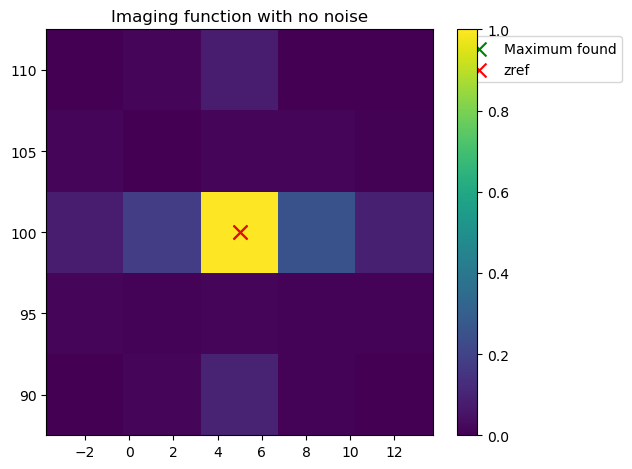

(5.0, 100.0)

In [52]:
res = 5
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid,max_I_coords = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
plot_result(I_grid, zref, max_I_coords)

On augmente la résolution

Difference between the ground truth and the maxima: 0.9090909090909065


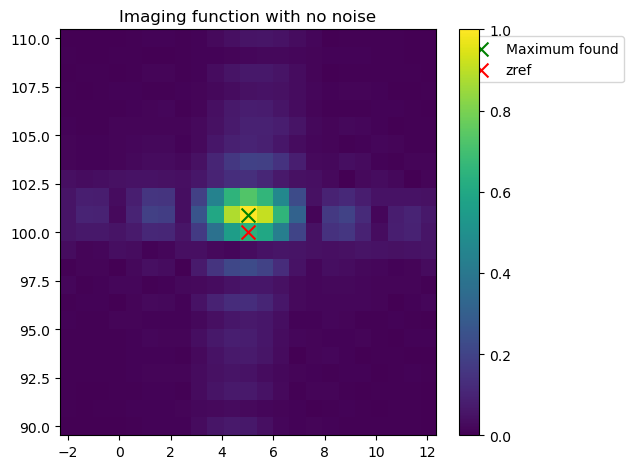

(5.0, 100.9090909090909)

In [53]:
res = 23
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid,max_I_coords = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
plot_result(I_grid, zref, max_I_coords,l_inf_x=l_inf_x,l_sup_x=l_sup_x,l_inf_y=l_inf_y,l_sup_y=l_sup_y)

Difference between the ground truth and the maxima: 1.1653468329202428


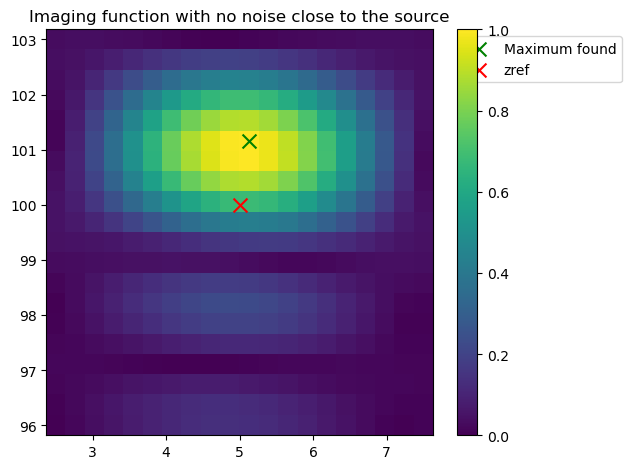

(5.131578947368421, 101.15789473684211)

In [54]:
res = 20
l_inf_close_x=2.5
l_sup_close_x=7.5
l_inf_close_y=96
l_sup_close_y=103
x = np.meshgrid(np.linspace(l_inf_close_x, l_sup_close_x, res), np.linspace(l_inf_close_y, l_sup_close_y, res))
I_grid,max_I_coords = compute_grid(l_inf_close_x, l_sup_close_x, l_inf_close_y, l_sup_close_y, res, zref, I_fun)
plot_result(I_grid, zref, max_I_coords,l_inf_y=l_inf_close_y,l_sup_y=l_sup_close_y,l_inf_x=l_inf_close_x,l_sup_x=l_sup_close_x,title="Imaging function with no noise close to the source")


Le maximum théorique et le maximum de la fonction d'image sont très proche. ils ne coincident pas à cause de problème d'intégration et de résolution.

# Stability Analysis

## First case: Data corrupted by an additive Gaussian Noise

In [31]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [32]:
noise = 0.01

In [33]:
# create an complex zero mean gaussian noise
def create_noise(n, sigma):
    z = np.random.normal(loc=0, scale=np.sqrt(2) / 2, size=(n, 2)).view(np.complex128)
    return z * sigma

On crée la fonction d'imagine avec du bruit sur les données

In [34]:
class Imagingfun_antennaNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w) + create_noise(1, self.noise).squeeze()
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun_antennaNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

1.0080556753171964e-06

In [35]:
res = 25
noise = 1e-7

In [36]:
import matplotlib.pyplot as plt


def plot_noise(noise, max_I_coords, zref):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem - zref[:2]))
    # plot in log scale
    plt.plot(noise, res)

    plt.xlabel("Noise")

    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima")
    plt.legend()
    return

def plot_noise_xy(noise,max_I_coords,zref):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem[0] - zref[0]))
    # plot in log scale
    plt.plot(noise, res)
    plt.xlabel("Noise")

    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima along the x axis ")
    plt.legend()
    plt.show() 

    fig= plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem[1] - zref[1]))
    # plot in log scale
    plt.plot(noise, res)
    plt.xlabel("Noise")
    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima along the y axis ")
    plt.legend()
    plt.show()
    return

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

noisel = [10**-k for k in range(1, 4)]


def compute_noise_data(noisel, ntry=4):
    max_I_coordsl = []

    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_antennaNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )
            I_grid,max_I_coords = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )

            max_I_coords_average.append(max_I_coords)

            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with noise of level {}".format(noise),
                )

        max_I_coords = np.mean(max_I_coords_average, axis=0)
        # plot it case
        # average the max_I_coords
        max_I_coordsl.append(max_I_coords)
    
    plot_noise(noisel, max_I_coordsl, zref)
    plot_noise_xy(noisel,max_I_coordsl,zref)

On plot en fonction du bruit les maximum trouvé 

Difference between the ground truth and the maxima 11.189342647755899


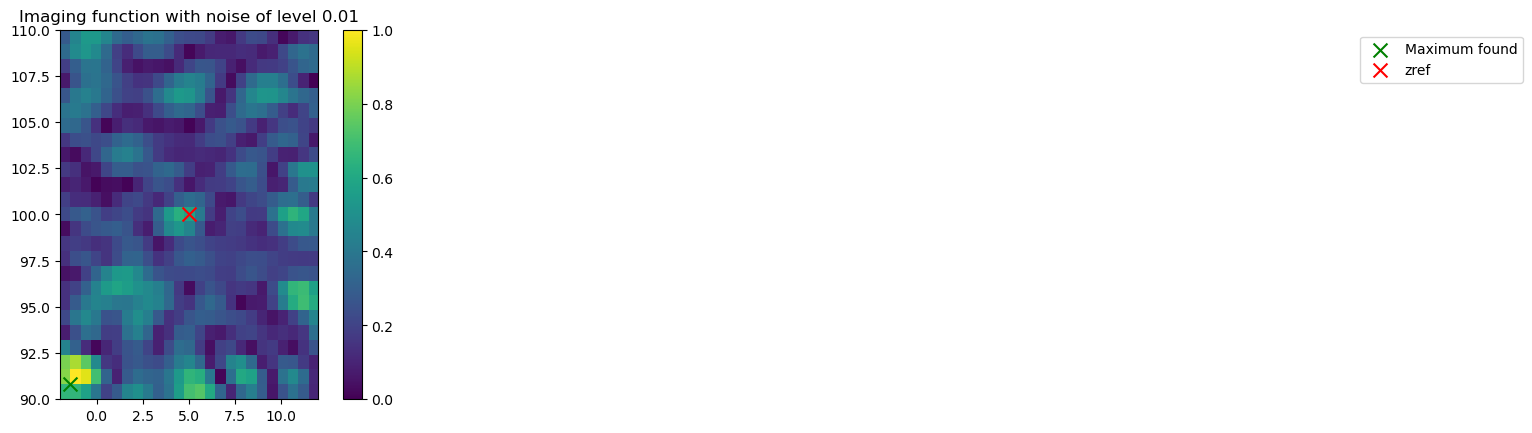

Difference between the ground truth and the maxima 3.0516389039334255


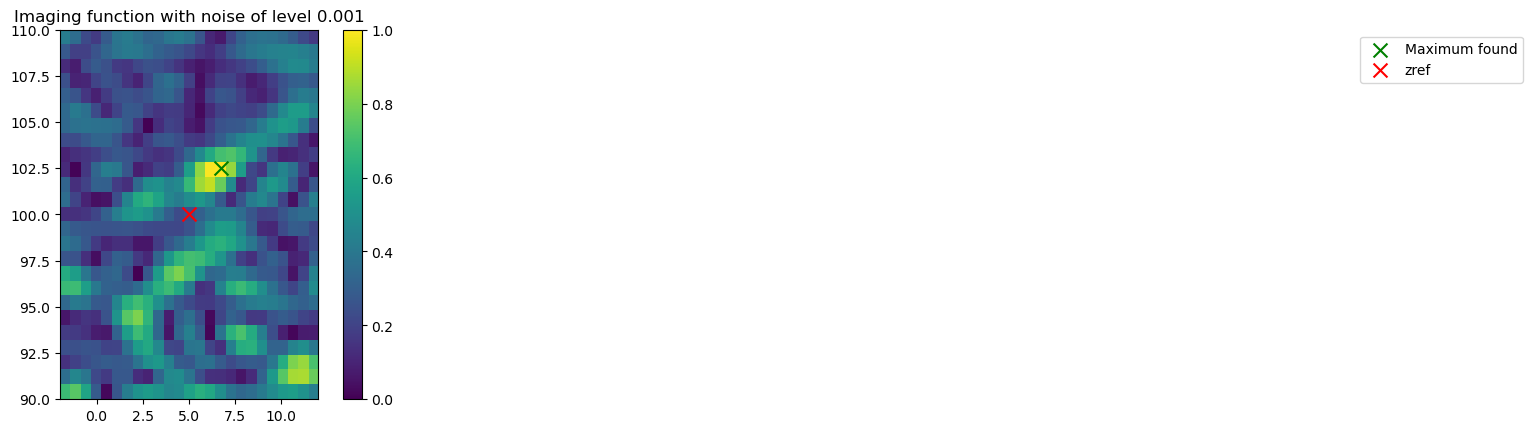

Difference between the ground truth and the maxima 1.1666666666666679


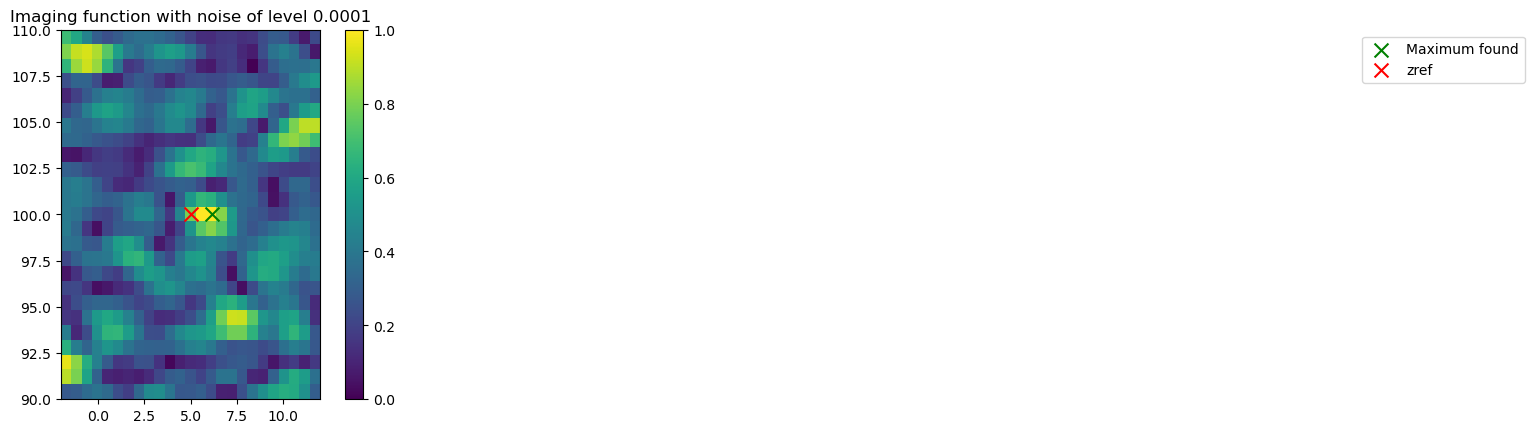

Difference between the ground truth and the maxima 0.8333333333333286


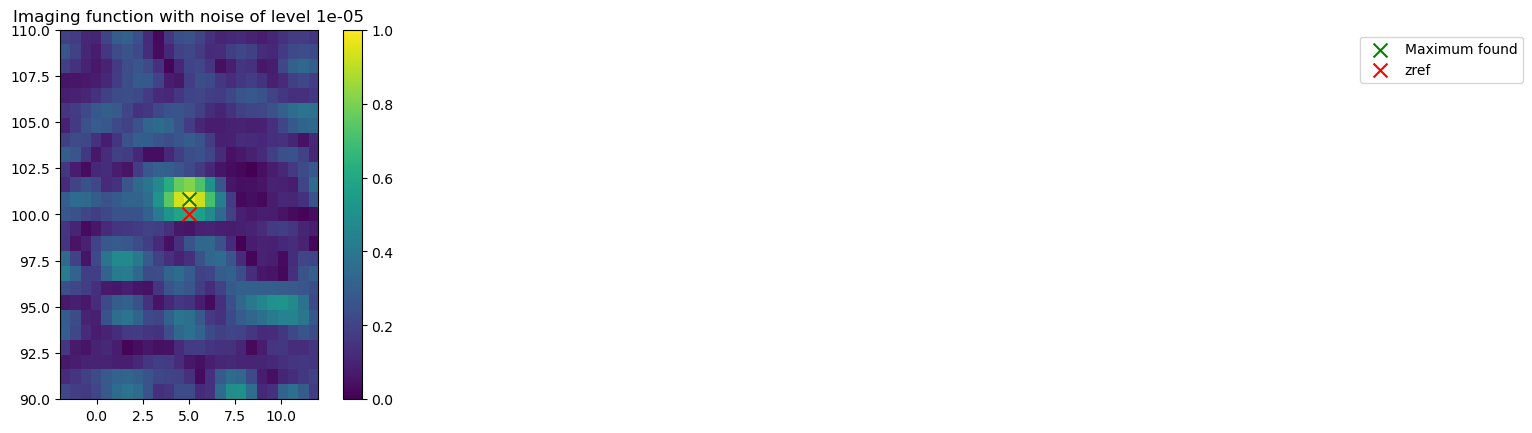

Difference between the ground truth and the maxima 0.8333333333333286


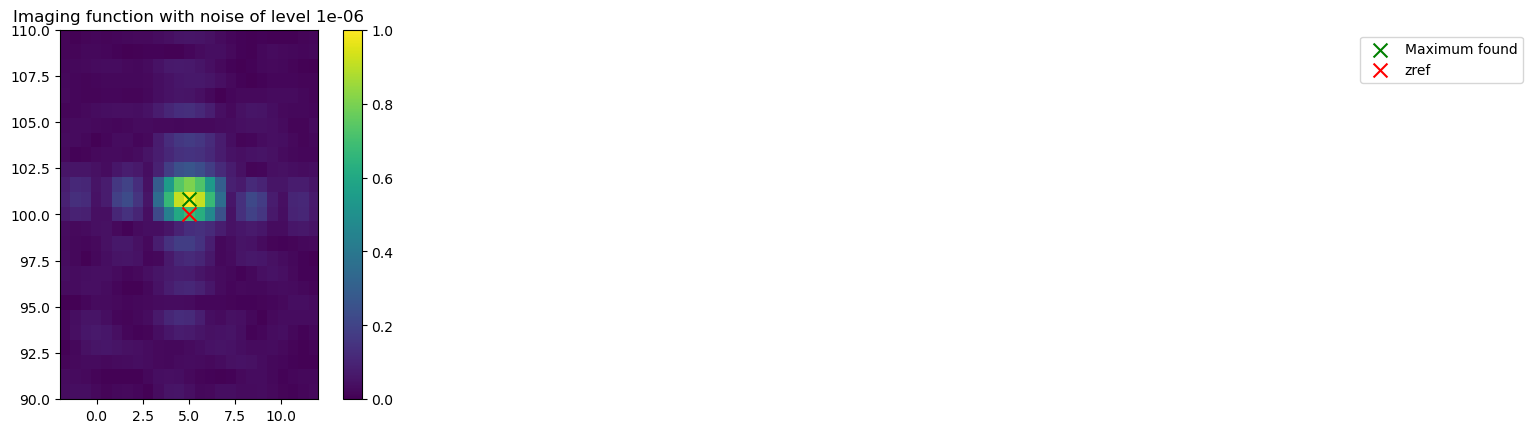

res []
res [9.0009644544966]
res [9.0009644544966, 5.535123016298337]
res [9.0009644544966, 5.535123016298337, 4.662619152484043]
res [9.0009644544966, 5.535123016298337, 4.662619152484043, 0.8459975210102851]
res []
res [0.875]
res [0.875, 2.770833333333334]
res [0.875, 2.770833333333334, 2.770833333333334]
res [0.875, 2.770833333333334, 2.770833333333334, 0.14583333333333393]


C:\Users\lix\AppData\Local\Temp\ipykernel_1016\2031496696.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\lix\AppData\Local\Temp\ipykernel_1016\2031496696.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


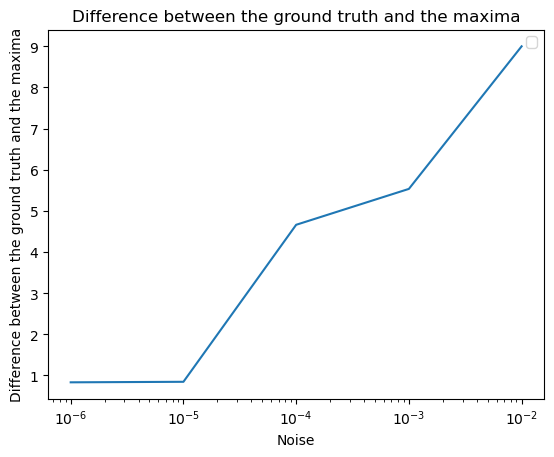

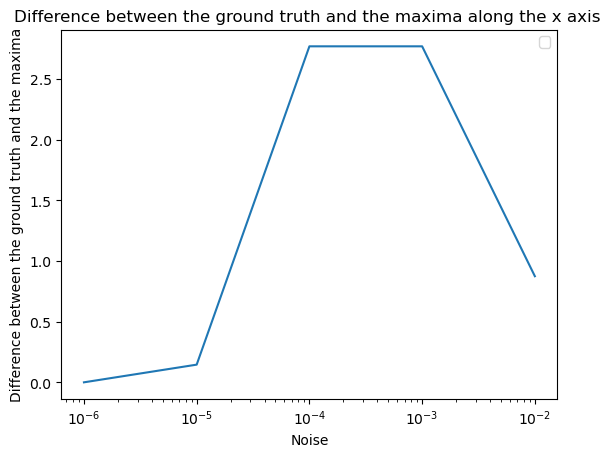

res []
res [8.958333333333343]
res [8.958333333333343, 4.791666666666671]
res [8.958333333333343, 4.791666666666671, 3.749999999999986]
res [8.958333333333343, 4.791666666666671, 3.749999999999986, 0.8333333333333286]


C:\Users\lix\AppData\Local\Temp\ipykernel_1016\2031496696.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


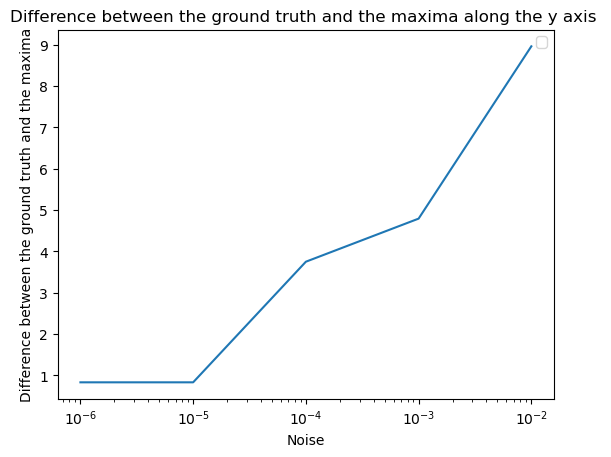

In [27]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = [10**-k for k in range(2, 7)]
compute_noise_data(noisel)

La différence de distance entre la vérité et le maximum augmente bien avec le bruit. Pour des valeurs de bruits trop élevés, la distance diminue mais cela est dû à la grid trop resérré

On concentre le graphique sur une plage de bruit ou les résultats semble cohérent:

In [38]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = np.linspace(5e-5, 1e-07, 10)
compute_noise_data(noisel)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

## Dernier cas:  Dans ce cas, la position des récepteurs est inconnus

In [ ]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [ ]:
sigma = 1

On crée ici la fonction d'imagerie correspondante

In [ ]:
class Imagingfun_positionNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)
        xn_noised = xn + np.random.randn(xn.shape[0], xn.shape[1]) * self.noise
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn_noised)
        self.second_term = self.constructR()

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.abs(Somme)


I_fun = Imagingfun_positionNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

Dans un premier temps on regarde pour des bruits entre 0.01 et 10

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = [10**k for k in range(-2, 2)]


def compute_noise_postion(noisel, ntry=4):
    max_I_coordsl = []
    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_positionNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )

            I_grid,max_I_coords = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )
            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with  Antenna noise of level {} ".format(
                        noise
                    ),
                )

            max_I_coords_average.append(max_I_coords)
        max_I_coords = np.mean(max_I_coords_average, axis=0)
        max_I_coordsl.append(max_I_coords)

    plot_noise(noisel, max_I_coordsl, zref)
    plot_noise_xy(noisel,max_I_coordsl,zref)
    return

In [ ]:
compute_noise_postion(noisel)

On se concentre maintenant au point d'inflexion, i.e entre 0.01 et 0.9 

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = np.linspace(0.01, 0.9, 10)
compute_noise_postion(noisel)

On a bien que la distance augmente avec le bruit. 